# Test Receipt Extraction

This notebook demonstrates the receipt extraction pipeline with composite sub-object support:
1. Find receipt subdocuments (from prior split-classify)
2. Inspect parsed receipt content
3. Run extraction — group 0 (header fields) + group 1 (line items)
4. Display results with references
5. Render PDF with bounding box overlays
6. Inspect Receipt target object from MongoDB

In [1]:
import sys, os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
os.chdir(PROJECT_ROOT)

from dotenv import load_dotenv
load_dotenv(os.path.join(PROJECT_ROOT, ".env"))
print(f"CWD: {os.getcwd()}")

CWD: /Users/vykhand/DEV/mydocs2


In [2]:
from lightodm import MongoConnection

conn = MongoConnection()
await conn.get_async_client()
print("Connected to MongoDB")

Connected to MongoDB


## 1. Find Receipt SubDocuments

Query documents that have subdocuments classified as `"receipt"` by the split-classify pipeline.

In [3]:
from mydocs.models import Document, DocumentPage
from IPython.display import display, HTML

# Find documents with receipt subdocuments
docs_with_receipts = await Document.afind(
    {"subdocuments.document_type": "receipt"}
)

print(f"Found {len(docs_with_receipts)} documents with receipt subdocuments\n")

# Build summary table
rows = ""
receipt_subdocs = []  # Collect all (doc, subdoc) pairs
for doc in docs_with_receipts:
    for sd in (doc.subdocuments or []):
        if sd.document_type == "receipt":
            page_nums = [pr.page_number for pr in sd.page_refs]
            receipt_subdocs.append((doc, sd))
            rows += (
                f"<tr><td>{doc.original_file_name}</td>"
                f"<td>{sd.id[:12]}...</td>"
                f"<td>{page_nums}</td>"
                f"<td>{len(page_nums)}</td></tr>\n"
            )

display(HTML(
    f"<p><b>Total receipt subdocuments:</b> {len(receipt_subdocs)}</p>"
    "<table border='1' cellpadding='4'>"
    "<tr><th>File</th><th>SubDoc ID</th><th>Pages</th><th># Pages</th></tr>"
    + rows + "</table>"
))

Found 19 documents with receipt subdocuments



File,SubDoc ID,Pages,# Pages
Receipt_20241016_0001.pdf,22665790e6f9...,[1],1
Receipt_20241016_0001.pdf,e57ab889710b...,[2],1
Receipt_20241016_0001.pdf,a63fd20923dc...,[3],1
Receipt_20241016_0001.pdf,471a9283fc25...,[4],1
Receipt_20241016_0001.pdf,4113c4212ca3...,[5],1
Receipt_20241016_0001.pdf,18b3e631c30f...,[6],1
Receipt_20241016_0001.pdf,70f2fd69fe1c...,[7],1
Receipt_20241016_0001.pdf,f0f470f27e98...,[8],1
Receipt_20241016_0001.pdf,528b4453f9a6...,[9],1
Receipt_20241016_0001.pdf,e441be8b8206...,[10],1


## 2. Inspect Receipt Content

Select a receipt subdocument and display its parsed `content_markdown`.

In [4]:
# Select the first receipt subdocument (change index to inspect others)
RECEIPT_INDEX = 0

assert len(receipt_subdocs) > RECEIPT_INDEX, "No receipt subdocuments found. Run split-classify first (notebook 002)."

selected_doc, selected_subdoc = receipt_subdocs[RECEIPT_INDEX]
DOCUMENT_ID = str(selected_doc.id)
SUBDOCUMENT_ID = selected_subdoc.id

print(f"Document: {selected_doc.original_file_name}")
print(f"SubDocument ID: {SUBDOCUMENT_ID}")
print(f"Pages: {[pr.page_number for pr in selected_subdoc.page_refs]}")

# Fetch and display the receipt's pages
page_ids = [pr.page_id for pr in selected_subdoc.page_refs]
pages = await DocumentPage.afind(
    {"_id": {"$in": page_ids}},
    sort=[("page_number", 1)],
)

for page in pages:
    print(f"\n{'='*60}")
    print(f"Page {page.page_number} ({page.width}x{page.height} {page.unit})")
    print(f"{'='*60}")
    content = page.content_markdown or page.content or "(no content)"
    print(content[:2000])

Document: Receipt_20241016_0001.pdf
SubDocument ID: 22665790e6f90ef1dff1501ee772084a
Pages: [1]

Page 1 (3.0833x15.2361 inch)
### Paragraphs

[p0] Mercator

[p1] Mercator d.o.o., Dunajska cesta 107, 1000 Ljubljana

[p2] ID za DDV: SI45884595

[p4] Valuta: EUR

[p6] Market Celovška 104 Celověka cesta 104,

[p7] LJUBLJANA

[p8] Datum/čas :

[p10] 15.10.2024

[p11] 16:41:52

[p12] Račun

[p13] :

[p15] 1079-3-157148

[p16] Interna številka

[p18] :

[p19] 160/03154838

[p20] Status

[p22] :

[p23] Potrjeno

[p25] Naziv artikla Cena/EM

[p27] Kol.

[p29] EM

[p30] Vrednost

[p32] VREČKA MERC.ZELENI LIST

[p33] VELIKA

[p34] 0,29

[p35] ŻEMLJA SOSED.BE.DP 70 G

[p36] 0,33

[p37] ŽEMLJA SOSED.BE.DP 70 G

[p38] 0,33

[p39] VODA JANA NEG.KOK.LIM.0,5L

[p40] -18,82% 0,85

[p41] 1

[p42] 0,69

[p43] VODA ZALA NEG.JAB.0,5L

[p44] 0,69

[p45] ČAJ TEEKA.ZEN CHAI ŽE.F20 35G

[p46] 2,07

[p47] NAPOL.KOESTLIN KARAT BAR

[p48] 26G

[p49] 0,45

[p50] KEKS LEIBNIZ ZOO OTR.100G

[p51] 1,89

[p52] PECIVO S

## 3. Run Receipt Extraction

Execute extraction on the selected receipt subdocument. This runs:
- **Group 0**: Header fields (merchant, date, totals, etc.) → `LLMFieldsResult` → flat enrichment
- **Group 1**: Line items → `LLMReceiptLineItemsResult` → composite enrichment

In [5]:
from mydocs.extracting.models import ExtractionRequest, ReferenceGranularity
from mydocs.extracting.extractor import BaseExtractor

request = ExtractionRequest(
    document_type="receipt",
    document_ids=[DOCUMENT_ID],
    subdocument_id=SUBDOCUMENT_ID,
    reference_granularity=ReferenceGranularity.FULL,
)

response = await BaseExtractor(request).run()

print(f"Document type: {response.document_type}")
print(f"Case type: {response.case_type}")
print(f"Model used: {response.model_used}")
print(f"Target object ID: {response.target_object_id}")
print(f"Reference granularity: {response.reference_granularity}")
print(f"\nResult keys: {list(response.results.keys())}")

[2026-02-19 13:22:40] [INFO] [extractor._resolve_subdocument:130] Scoped to subdocument 22665790e6f90ef1dff1501ee772084a: type=receipt, pages=1
[2026-02-19 13:22:40] [INFO] [prompt_utils.get_all_fields:159] Loaded 15 fields for generic/receipt
[2026-02-19 13:22:40] [INFO] [retrievers.get_pages_retriever:204] Pages retriever returned 1 pages
[2026-02-19 13:23:04] [INFO] [retrievers.get_pages_retriever:204] Pages retriever returned 1 pages
[2026-02-19 13:23:16] [DEBUG] [extractor._save_results:404] Saved field result: dc658277108566bf53c497ae0021e57c/summary
[2026-02-19 13:23:16] [DEBUG] [extractor._save_results:404] Saved field result: dc658277108566bf53c497ae0021e57c/merchant_name
[2026-02-19 13:23:16] [DEBUG] [extractor._save_results:404] Saved field result: dc658277108566bf53c497ae0021e57c/merchant_address
[2026-02-19 13:23:17] [DEBUG] [extractor._save_results:404] Saved field result: dc658277108566bf53c497ae0021e57c/receipt_number
[2026-02-19 13:23:17] [DEBUG] [extractor._save_resul

## 4. Display Header Field Results

Show extracted header fields in a table with content, justification, citation, and reference count.

In [6]:
# Header fields (non-composite results)
header_fields = [
    "summary", "merchant_name", "merchant_address", "receipt_number",
    "transaction_date", "payment_method", "country",
    "subtotal", "tax_total", "total_amount", "currency",
]

rows = ""
for field_name in header_fields:
    result = response.results.get(field_name)
    if result is None:
        continue
    content = str(result.get("content", ""))[:80]
    justification = str(result.get("justification", ""))[:80]
    citation = str(result.get("citation", ""))[:80]
    refs = result.get("references") or []
    rows += (
        f"<tr><td><b>{field_name}</b></td>"
        f"<td>{content}</td>"
        f"<td>{justification}</td>"
        f"<td>{citation}</td>"
        f"<td>{len(refs)}</td></tr>\n"
    )

display(HTML(
    "<h3>Header Fields</h3>"
    "<table border='1' cellpadding='4'>"
    "<tr><th>Field</th><th>Content</th><th>Justification</th><th>Citation</th><th># Refs</th></tr>"
    + rows + "</table>"
))

Field,Content,Justification,Citation,# Refs
summary,"Mercator, Ljubljana, Slovenia, 2024-10-15, total amount 16.23 EUR.","The summary includes the merchant name (Mercator), location (Ljubljana, Slovenia","Mercator Mercator d.o.o., Dunajska cesta 107, 1000 Ljubljana Datum/čas : 15.10.2",6
merchant_name,Mercator,The merchant name is clearly stated at the top of the receipt and in the address,"Mercator Mercator d.o.o., Dunajska cesta 107, 1000 Ljubljana",2
merchant_address,"Dunajska cesta 107, 1000 Ljubljana","The full address is provided under the merchant name, including street and posta","Mercator d.o.o., Dunajska cesta 107, 1000 Ljubljana",1
receipt_number,1079-3-157148,The receipt number is labeled as 'Račun' and appears in both paragraph and table,Račun : 1079-3-157148,4
transaction_date,2024-10-15,The transaction date is shown as 'Datum/čas : 15.10.2024' and also in key-value,Datum/čas : 15.10.2024,4
payment_method,Credit Card,"The payment method is indicated as 'MASTERCARD', which is a credit card.",-- Plaćano -- MASTERCARD Mastercard/Eurocard,3
country,Slovenia,"The address (Ljubljana), VAT ID format (SI...), and language indicate Slovenia.","Mercator d.o.o., Dunajska cesta 107, 1000 Ljubljana ID za DDV: SI45884595",2
subtotal,14.80,"The subtotal before tax is labeled as 'Osnova' in the tax summary table, with th","Osnova 14,80",3
tax_total,1.43,"The total tax amount is labeled as 'DDV' in the tax summary table, with the sum","DDV 1,43",3
total_amount,16.23,"The total amount is labeled as 'Skupaj (EUR)', 'ZA PLAČILO (EUR)', and 'ZNESEK',","Skupaj (EUR) 16,23 ZA PLAČILO (EUR) 16,23 ZNESEK : 16,23 EUR",9


## 5. Display Line Items

Show extracted line items in a structured table.

In [7]:
# Line items (composite results)
line_items = response.results.get("line_items", [])

if not line_items:
    print("No line items extracted.")
else:
    rows = ""
    for i, item in enumerate(line_items):
        desc = item.get("item_description", {}).get("content", "")
        qty = item.get("quantity", {}).get("content", "")
        price = item.get("unit_price", {}).get("content", "")
        total = item.get("line_total", {}).get("content", "")
        # Count references across all sub-fields
        ref_count = sum(
            len(item.get(f, {}).get("references", []) or [])
            for f in ["item_description", "quantity", "unit_price", "line_total"]
        )
        rows += (
            f"<tr><td>{i+1}</td>"
            f"<td>{desc}</td>"
            f"<td>{qty}</td>"
            f"<td>{price}</td>"
            f"<td>{total}</td>"
            f"<td>{ref_count}</td></tr>\n"
        )

    display(HTML(
        f"<h3>Line Items ({len(line_items)} items)</h3>"
        "<table border='1' cellpadding='4'>"
        "<tr><th>#</th><th>Description</th><th>Qty</th><th>Unit Price</th><th>Line Total</th><th># Refs</th></tr>"
        + rows + "</table>"
    ))

#,Description,Qty,Unit Price,Line Total,# Refs
1,VREČKA MERC.ZELENI LIST VELIKA,1,0.29,0.29,4
2,ŻEMLJA SOSED.BE.DP 70 G,1,0.33,0.33,4
3,ŽEMLJA SOSED.BE.DP 70 G,1,0.33,0.33,4
4,"VODA JANA NEG.KOK.LIM.0,5L",1,0.69,0.69,4
5,"VODA ZALA NEG.JAB.0,5L",1,0.69,0.69,4
6,ČAJ TEEKA.ZEN CHAI ŽE.F20 35G,1,2.07,2.07,4
7,NAPOL.KOESTLIN KARAT BAR 26G,1,0.45,0.45,4
8,KEKS LEIBNIZ ZOO OTR.100G,1,1.89,1.89,4
9,PECIVO SL.ELEPHANT SEZAM 80G,1,1.19,1.19,4
10,NAPITEK JOG. JAG. ACTIMEL 100GX6,1,3.29,3.29,4


## 6. Render PDF with Reference Bounding Boxes

Overlay extracted references on the PDF pages using PyMuPDF.

In [8]:
try:
    import fitz  # PyMuPDF
except ImportError:
    raise ImportError("Install PyMuPDF: pip install pymupdf")

from IPython.display import display, Image as IPImage


# Colour palette for fields
FIELD_COLORS = {
    "summary": (0, 0.5, 1),
    "merchant_name": (1, 0, 0),
    "merchant_address": (0.8, 0.4, 0),
    "receipt_number": (0, 0.7, 0),
    "transaction_date": (0.6, 0, 0.8),
    "payment_method": (0.8, 0, 0.4),
    "total_amount": (0, 0.7, 0.7),
    "line_item": (0.5, 0.5, 0),
}


def polygon_to_fitz_rect(polygon, page_width, page_height, page_unit, pdf_page):
    """Convert a mydocs polygon to a fitz.Rect."""
    if len(polygon) < 8:
        return fitz.Rect(0, 0, 0, 0)
    min_x, min_y = polygon[0], polygon[1]
    max_x, max_y = polygon[4], polygon[5]
    if page_width and page_height:
        fx0, fy0 = min_x / page_width, min_y / page_height
        fx1, fy1 = max_x / page_width, max_y / page_height
    else:
        fx0, fy0, fx1, fy1 = 0, 0, 0, 0
    pdf_rect = pdf_page.rect
    return fitz.Rect(
        pdf_rect.width * fx0, pdf_rect.height * fy0,
        pdf_rect.width * fx1, pdf_rect.height * fy1,
    )


print("Rendering helpers loaded.")

Rendering helpers loaded.


In [9]:
# Collect all references from header fields AND line items
all_refs = []  # list of (label, ref_dict)

# Header field references
for field_name in header_fields:
    result = response.results.get(field_name)
    if result is None:
        continue
    for ref in (result.get("references") or []):
        all_refs.append((field_name, ref))

# Line item references
for i, item in enumerate(line_items):
    for sub_field in ["item_description", "quantity", "unit_price", "line_total"]:
        sub_result = item.get(sub_field, {})
        for ref in (sub_result.get("references") or []):
            all_refs.append((f"line_item_{i}_{sub_field}", ref))

print(f"Total references to render: {len(all_refs)}")

# Group by page
refs_by_page = {}
for label, ref in all_refs:
    pg = ref["page_number"]
    refs_by_page.setdefault(pg, []).append((label, ref))

print(f"Pages with references: {sorted(refs_by_page.keys())}")

Total references to render: 102
Pages with references: [1]


PDF path: /Users/vykhand/Library/CloudStorage/OneDrive-Personal/Documents/SCANS/epson/workforce/Receipt_20241016_0001.pdf

--- Page 1 (102 references) ---


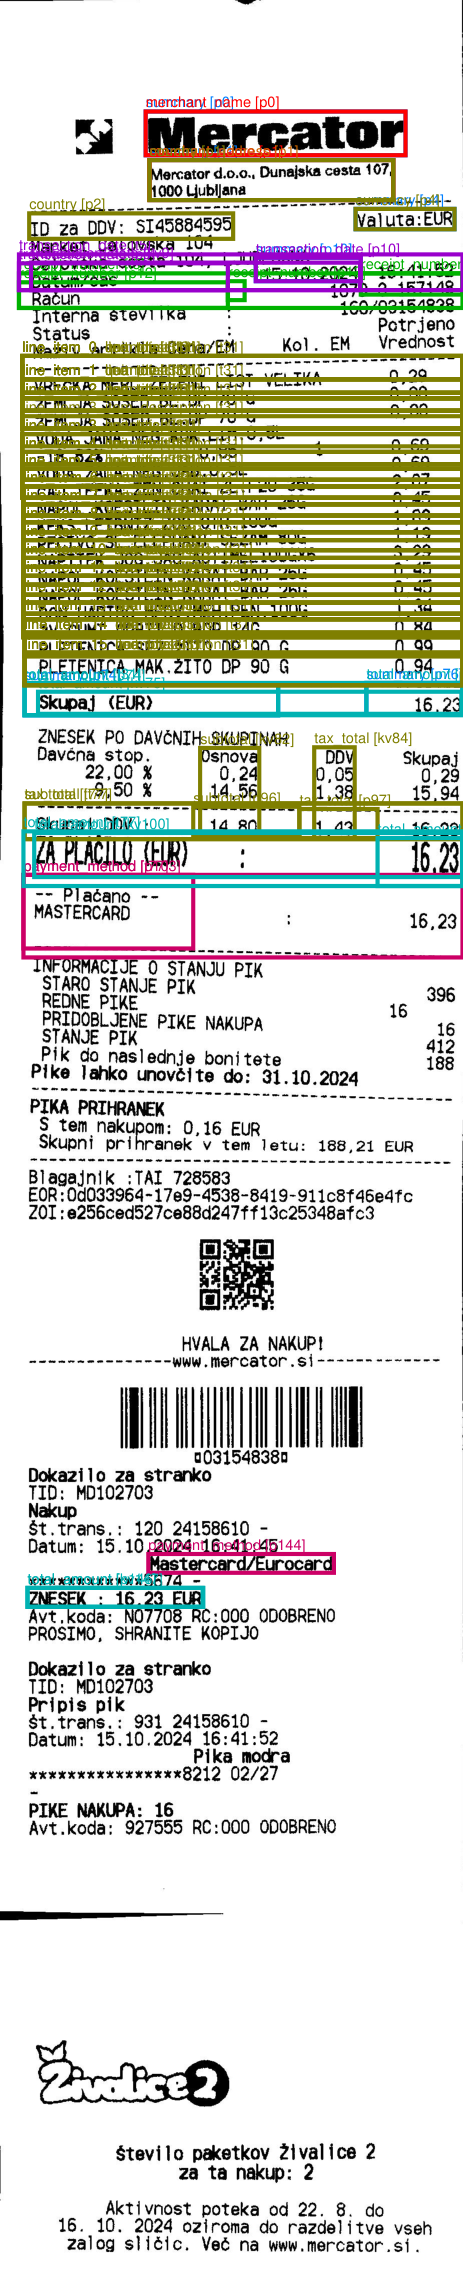

In [10]:
# Resolve PDF path
doc = await Document.aget(DOCUMENT_ID)
pdf_path = doc.managed_path or doc.original_path
print(f"PDF path: {pdf_path}")

# Render each page with references
for page_num in sorted(refs_by_page.keys()):
    page_refs = refs_by_page[page_num]
    print(f"\n--- Page {page_num} ({len(page_refs)} references) ---")

    pdf = fitz.open(pdf_path)
    page = pdf[page_num - 1]

    for label, ref in page_refs:
        polygon = ref.get("polygon", [])
        if not polygon:
            continue
        rect = polygon_to_fitz_rect(
            polygon, ref.get("page_width", 0),
            ref.get("page_height", 0), ref.get("page_unit", "inch"), page,
        )
        # Pick colour: use field-specific if header, else line_item colour
        base_field = label.split("_")[0] if not label.startswith("line_item") else "line_item"
        color = FIELD_COLORS.get(label, FIELD_COLORS.get(base_field, (0.5, 0.5, 0)))
        page.draw_rect(rect, color=color, width=2)
        short_label = f"{label} [{ref.get('element_short_id', '')}]"
        page.insert_text(
            fitz.Point(rect.x0, rect.y0 - 2),
            short_label, fontsize=7, color=color,
        )

    mat = fitz.Matrix(150 / 72, 150 / 72)
    pix = page.get_pixmap(matrix=mat)
    display(IPImage(data=pix.tobytes("png")))
    pdf.close()

## 7. Inspect Receipt Target Object

Query the `receipts` collection and display the populated Receipt with line_items.

In [11]:
from mydocs.extracting.case_types.generic.models import Receipt

# Query the receipt target object
receipts = await Receipt.afind({
    "document_id": DOCUMENT_ID,
    "subdocument_id": SUBDOCUMENT_ID,
})

if not receipts:
    print("No Receipt target object found.")
else:
    receipt = receipts[0]
    print(f"Receipt ID: {receipt.id}")
    print(f"Document ID: {receipt.document_id}")
    print(f"SubDocument ID: {receipt.subdocument_id}")
    print()

    # Display header fields
    for field_name in header_fields:
        value = getattr(receipt, field_name, None)
        if value and hasattr(value, "content"):
            print(f"  {field_name}: {value.content}")
        else:
            print(f"  {field_name}: {value}")

    # Display line items
    print(f"\n  line_items: {len(receipt.line_items or [])} items")
    if receipt.line_items:
        for i, li in enumerate(receipt.line_items):
            desc = li.item_description.content if li.item_description else ""
            qty = li.quantity.content if li.quantity else ""
            price = li.unit_price.content if li.unit_price else ""
            total = li.line_total.content if li.line_total else ""
            print(f"    [{i+1}] {desc} | qty={qty} | price={price} | total={total}")

Receipt ID: 36a61296adc309540c46fba10583c704
Document ID: dc658277108566bf53c497ae0021e57c
SubDocument ID: 22665790e6f90ef1dff1501ee772084a

  summary: Mercator, Ljubljana, Slovenia, 2024-10-15, total amount 16.23 EUR.
  merchant_name: Mercator
  merchant_address: Dunajska cesta 107, 1000 Ljubljana
  receipt_number: 1079-3-157148
  transaction_date: 2024-10-15
  payment_method: Credit Card
  country: Slovenia
  subtotal: 14.80
  tax_total: 1.43
  total_amount: 16.23
  currency: EUR

  line_items: 16 items
    [1] VREČKA MERC.ZELENI LIST VELIKA | qty=1 | price=0.29 | total=0.29
    [2] ŻEMLJA SOSED.BE.DP 70 G | qty=1 | price=0.33 | total=0.33
    [3] ŽEMLJA SOSED.BE.DP 70 G | qty=1 | price=0.33 | total=0.33
    [4] VODA JANA NEG.KOK.LIM.0,5L | qty=1 | price=0.69 | total=0.69
    [5] VODA ZALA NEG.JAB.0,5L | qty=1 | price=0.69 | total=0.69
    [6] ČAJ TEEKA.ZEN CHAI ŽE.F20 35G | qty=1 | price=2.07 | total=2.07
    [7] NAPOL.KOESTLIN KARAT BAR 26G | qty=1 | price=0.45 | total=0.45
    [8]

## 8. Run on a Different Receipt

Change `RECEIPT_INDEX` in cell 6 above and re-run from there, or set a specific
document_id and subdocument_id below.

In [ ]:
# # Override to run on a specific receipt:
# DOCUMENT_ID = "your_document_id"
# SUBDOCUMENT_ID = "your_subdocument_id"
#
# request = ExtractionRequest(
#     document_type="receipt",
#     document_ids=[DOCUMENT_ID],
#     subdocument_id=SUBDOCUMENT_ID,
#     reference_granularity=ReferenceGranularity.FULL,
# )
# response = await BaseExtractor(request).run()
# print(f"Results: {list(response.results.keys())}")

## Cleanup (optional)

Uncomment to delete extracted results and target objects.

In [ ]:
# from mydocs.extracting.models import FieldResultRecord
#
# await FieldResultRecord.adelete_many({"document_id": DOCUMENT_ID, "subdocument_id": SUBDOCUMENT_ID})
# await Receipt.adelete_many({"document_id": DOCUMENT_ID, "subdocument_id": SUBDOCUMENT_ID})
# print(f"Cleaned up results for {DOCUMENT_ID}/{SUBDOCUMENT_ID}")